Total Object Dimensions - Length: 5.719 cm, Width: 5.4940999999999995  cm , Height: 5.303999999999999 cm
Bottom Surface Dimensions - Length: 5.719003088260001,cm Width: 5.494102966813999 cm 
Total Object Dimensions - Length: 9.608 cm, Width: 20.152399999999997  cm , Height: 1.5671000000000002 cm
Bottom Surface Dimensions - Length: 9.60800518832,cm Width: 20.152410882296 cm 
Total Object Dimensions - Length: 10.2433 cm, Width: 6.769900000000001  cm , Height: 25.058000000000003 cm
Bottom Surface Dimensions - Length: 10.072205438988002,cm Width: 6.769903655746001 cm 
Total Object Dimensions - Length: 6.411899999999999 cm, Width: 3.2515  cm , Height: 2.3928 cm
Bottom Surface Dimensions - Length: 6.411903462426,cm Width: 3.25150175581 cm 
Total Object Dimensions - Length: 9.536999999999999 cm, Width: 9.617400000000002  cm , Height: 9.459100000000001 cm
Bottom Surface Dimensions - Length: 9.53700514998,cm Width: 9.617405193396001 cm 
Total Object Dimensions - Length: 7.180000000000001 cm, Wi

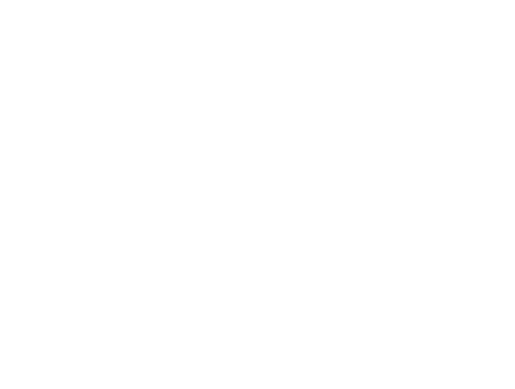

In [31]:
import numpy as np
import pywavefront
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw, ImageFont
import io
import os

# Base directory path (Change this to your local machine path)
base_dir = '/home/jose/Downloads/GraspBenchmarkWorkspace/YCB/models/ycb/'
#Change the output path based on where you want to save the final outcomes
out_path = '/home/jose/Downloads/templates/'


dpi=300
MARKER_ID = 6
ARUCO_SIZE = 500  # The size of the ARUCO marke
ARUCO_DICT = cv2.aruco.DICT_4X4_250  # The ARUCO dictionary
a3_size_inches = (11.7, 16.5)  # A3 size in inches
inch_to_cm_conversion_factor = 2.54


def load_mesh_model(file_path):
    scene = pywavefront.Wavefront(file_path)
    items = list(scene.materials.items())
    ver = items[0][1].vertices
    n_ver = int(len(ver)/8)
    v = np.zeros((n_ver,3))
    for i in range(n_ver):
        v[i,:] = ver[8*i+5:8*i+5+3]
    return v

def calculate_dimensions(vertices):
    x_min, x_max = np.min(vertices[:, 0]), np.max(vertices[:, 0])
    y_min, y_max = np.min(vertices[:, 1]), np.max(vertices[:, 1])
    z_min, z_max = np.min(vertices[:, 2]), np.max(vertices[:, 2])
    return x_max - x_min, y_max - y_min, z_max - z_min


def find_intersection(pil_image):
    # Convert to RGB
    image = np.array(pil_image.convert('RGB'))
    plt.axis('off')  # Turn off axis numbers
    lower_red = np.array([100, 0, 0])
    upper_red = np.array([255, 100, 100])
    lower_green = np.array([0, 100, 0])  # Adjust these values based on your actual green
    upper_green = np.array([100, 255, 100])  
    
    # Threshold the RGB image to get only red and green colors
    mask_red = cv2.inRange(image, lower_red, upper_red)
    mask_green = cv2.inRange(image, lower_green, upper_green)
    
    # Find contours for the red and green lines
    contours_red, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_green, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if contours are found, if not, print an error message
    if not contours_red or not contours_green:
        print("No contours found for red or green lines. Check the color thresholds and make sure the lines are visible in the image.")

    else:
        # Assume the longest contour in each color is the line we want
        red_line = max(contours_red, key=cv2.contourArea)
        green_line = max(contours_green, key=cv2.contourArea)
    
        # Find the endpoints of each line
        red_line_endpoint = tuple(red_line[red_line[:, :, 0].argmin()][0])
        green_line_endpoint = tuple(green_line[green_line[:, :, 0].argmin()][0])
    
        # Now, we find the point closest between the two lines
        # For simplicity, we are assuming that they join at the ends closest to the origin (0,0)
        joint_point = (max(red_line_endpoint[0], green_line_endpoint[0]), max(red_line_endpoint[1], green_line_endpoint[1]))
    
        # Draw a black circle at the joint point
        cv2.circle(image, joint_point, 200, (0,0,0), 2)  # Circle with a thickness of 2 pixels
    
        # Convert joint point to inches
        scaling_factor_x = 11.69/ image.shape[1]
        scaling_factor_y = 16.54 / image.shape[0]
    
        real_world_x = joint_point[0] * scaling_factor_x
        real_world_y = (image.shape[0] - joint_point[1]) * scaling_factor_y  # Convert y-coordinate because image origin (0,0) is at the top-left
        joint_point_inches = (real_world_x,real_world_y)
        plt.axis('off')  # Turn off axis numbers
        
    
     
    return joint_point,joint_point_inches




def create_a3_canvas_with_aruco_and_origin_axes(vertices, marker_id, aruco_size, aruco_dict, z_threshold=0.05, dpi=300, save_path='a3_with_aruco.png'):
    meter_to_inch = 39.3701  # conversion factor from meters to inches
    cm_to_inch = 0.393701  # conversion factor from cm to inches
    a3_size_inches = (11.7, 16.5)  # A3 size in inches

    # Create ARUCO marker
    aruco_dict = cv2.aruco.Dictionary_get(aruco_dict)
    marker_image = cv2.aruco.drawMarker(aruco_dict, marker_id, aruco_size)
    marker_pil_img = Image.fromarray(marker_image)
    # Rotate the marker by 90 degrees clockwise
    marker_image_rotated = marker_pil_img.rotate(-90, expand=1)
   
   

    # Convert rotated ARUCO marker to an image that can be placed on the plot
    aruco_fig = plt.figure(figsize=(1.57480315, 1.57480315), dpi=dpi)
    aruco_ax = aruco_fig.add_subplot(111)
    aruco_ax.imshow(marker_image_rotated, cmap='gray')
    aruco_ax.axis('off')
    aruco_fig.canvas.draw()

    # Extract ARUCO marker image and place it on the A3 canvas
    aruco_data = np.frombuffer(aruco_fig.canvas.tostring_rgb(), dtype=np.uint8)
    aruco_data = aruco_data.reshape(aruco_fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(aruco_fig)

    # Generate bottom surface plot
    z_min = np.min(vertices[:, 2])
    bottom_vertices = vertices[np.abs(vertices[:, 2] - z_min) <= z_threshold]
    x_min, x_max = np.min(bottom_vertices[:, 0]), np.max(bottom_vertices[:, 0])
    y_min, y_max = np.min(bottom_vertices[:, 1]), np.max(bottom_vertices[:, 1])

    # Convert from meters to inches for plot dimensions
    plot_width_inch = (x_max - x_min) * meter_to_inch
    plot_bredth_inch = (y_max - y_min) * meter_to_inch

    # Create an A3-sized canvas
    fig = plt.figure(figsize=a3_size_inches, dpi=dpi)
    ax = fig.add_subplot(111)

    # Centering the plot on the A3 canvas
    x_offset = (a3_size_inches[0] - plot_width_inch) / 2
    y_offset = (a3_size_inches[1] - plot_bredth_inch) / 2

    # Adjust vertices to fit the new origin and plot them
    adjusted_vertices = bottom_vertices * meter_to_inch
    adjusted_vertices[:, 0] += x_offset - x_min * meter_to_inch
    adjusted_vertices[:, 1] += y_offset - y_min * meter_to_inch
    ax.scatter(adjusted_vertices[:, 0], adjusted_vertices[:, 1])

    # Locate the (0,0) point within the adjusted vertices
    origin_x = x_offset - x_min * meter_to_inch
    origin_y = y_offset - y_min * meter_to_inch

    # Draw X and Y axes lines starting from the (0,0) point
    ax.plot([origin_x, origin_x + cm_to_inch], [origin_y, origin_y], 'r-', lw=2)  # X-axis in red
    ax.plot([origin_x, origin_x], [origin_y, origin_y + cm_to_inch], 'g-', lw=2)  # Y-axis in green
    
    # Place ARUCO marker on the A3 canvas at the top middle
    ax.imshow(aruco_data, extent=[(a3_size_inches[0] - aruco_size/dpi)/2, (a3_size_inches[0] + aruco_size/dpi)/2, a3_size_inches[1] - aruco_size/dpi, a3_size_inches[1]], zorder=2)

    # Set the limits of the A3 canvas
    ax.set_xlim([0, a3_size_inches[0]])
    ax.set_ylim([0, a3_size_inches[1]])

    # Remove axes for clarity
    ax.axis('off')

    # Save the image
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    # Instead of saving the image, save it to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img = Image.open(buf)

    # Close plt and buffer to free up memory
    plt.close()
    return img,plot_width_inch,plot_bredth_inch
    
def trim_white_border(img):
    bg = Image.new(img.mode, img.size, img.getpixel((0,0)))
    diff = ImageChops.difference(img, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return img.crop(bbox)

def create_a3_canvas_with_aruco_and_origin_axes_modification(model_dir,save_path,previous_fig,vertices, marker_id, aruco_size, aruco_dict, joint_point, z_threshold=0.05, dpi=300):

    # Convert PIL image to NumPy array
    image = np.array(previous_fig)
    meter_to_inch = 39.3701  # conversion factor from meters to inches
    cm_to_inch = 0.393701  # conversion factor from cm to inches
    a3_size_inches = (11.7, 16.5)  # A3 size in inches

    # Convert joint point to inches
    scaling_factor_x = 11.69/ image.shape[1]
    scaling_factor_y = 16.54 / image.shape[0]


    real_world_x = joint_point[0]
    real_world_y = joint_point[1]
    
    # Create ARUCO marker
    aruco_dict = cv2.aruco.Dictionary_get(aruco_dict)
    marker_image = np.zeros((aruco_size, aruco_size), dtype=np.uint8)
    marker_image = cv2.aruco.drawMarker(aruco_dict, marker_id, aruco_size)
    marker_pil_img = Image.fromarray(marker_image)
    marker_image_rotated = marker_pil_img.rotate(-90, expand=1)
    aruco_width,aruco_height = marker_image_rotated.size


    # Convert rotated ARUCO marker to an image that can be placed on the plot
    aruco_fig = plt.figure(figsize=(aruco_width/dpi, aruco_height/dpi), dpi=dpi)
    aruco_ax = aruco_fig.add_subplot(111)
    aruco_ax.axis('off')
    aruco_ax.imshow(marker_image_rotated, cmap='gray')
    numpy_marker_image = np.array(aruco_fig)
    aruco_fig.canvas.draw()

    # Extract ARUCO marker image and place it on the A3 canvas
    aruco_data = np.frombuffer(aruco_fig.canvas.tostring_rgb(), dtype=np.uint8)
    aruco_data = aruco_data.reshape(aruco_fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(aruco_fig)

    # Generate bottom surface plot
    z_min = np.min(vertices[:, 2])
    bottom_vertices = vertices[np.abs(vertices[:, 2] - z_min) <= z_threshold]
    x_min, x_max = np.min(bottom_vertices[:, 0]), np.max(bottom_vertices[:, 0])
    y_min, y_max = np.min(bottom_vertices[:, 1]), np.max(bottom_vertices[:, 1])

    # Convert from meters to inches for plot dimensions
    plot_width_inch = (x_max - x_min) * meter_to_inch
    plot_bredth_inch = (y_max - y_min) * meter_to_inch

    # Create an A3-sized canvas
    fig = plt.figure(figsize=a3_size_inches, dpi=dpi)
    ax = fig.add_subplot(111)

    # Centering the plot on the A3 canvas
    x_offset = (a3_size_inches[0] - plot_width_inch) / 2
    y_offset = (a3_size_inches[1] - plot_bredth_inch) / 2

    # Adjust vertices to fit the new origin and plot them
    adjusted_vertices = bottom_vertices * meter_to_inch
    adjusted_vertices[:, 0] += x_offset - x_min * meter_to_inch
    adjusted_vertices[:, 1] += y_offset - y_min * meter_to_inch
    ax.scatter(adjusted_vertices[:, 0], adjusted_vertices[:, 1])

    # Locate the (0,0) point within the adjusted vertices
    origin_x = x_offset - x_min * meter_to_inch
    origin_y = y_offset - y_min * meter_to_inch

    # Draw X and Y axes lines starting from the (0,0) point
    ax.plot([origin_x, origin_x + cm_to_inch], [origin_y, origin_y], 'r-', lw=2)  # X-axis in red
    ax.plot([origin_x, origin_x], [origin_y, origin_y + cm_to_inch], 'g-', lw=2)  # Y-axis in green
    
    # Place ARUCO marker on the A3 canvas at the top middle
    ax.imshow(aruco_data, extent=[real_world_x-0.25, (real_world_x+ 1.5748+0.19685), a3_size_inches[1] - 1.5748-0.393701-0.05905512, a3_size_inches[1]], zorder= 2)#a3_size_inches[0] + aruco_size/dpi)/2, a3_size_inches[1] - aruco_size/dpi
    
    # ArUco marker's left bottom corner (assuming you know its position on the canvas)
    aruco_left_bottom_x = real_world_x - 0.25  # Adjust based on actual position
    aruco_left_bottom_y = a3_size_inches[1] - 1.5748  # Adjust based on actual position

    # Draw a line from the intersection point to the ArUco marker's left bottom corner
    ax.plot([joint_point[0], aruco_left_bottom_x+0.25], [joint_point[1], aruco_left_bottom_y -0.20], 'b-', lw=2)  # Line in blue
    # Add X and Y notations around the ArUco marker
    ax.text(real_world_x-0.5, aruco_left_bottom_y + 0.5 , 'Y', color='Black', fontsize=12)  # Below the marker
    ax.text(real_world_x + 0.5, aruco_left_bottom_y - 0.5, 'X', color='Black', fontsize=12)  # To the right of the marker
    
    # Draw arrow lines around the ArUco marker
    # Vertical line (Y direction)
    ax.arrow(real_world_x-0.5, aruco_left_bottom_y +0.5 , 0, 0.4, head_width=0.1, head_length=0.2, fc='k', ec='k', lw=2)
    # Horizontal line (X direction)
    ax.arrow(real_world_x+0.5 , aruco_left_bottom_y- 0.5, 0.4, 0, head_width=0.1, head_length=0.2, fc='k', ec='k', lw=2)

    # Calculate the physical length of the line in inches
    line_length_inches = np.sqrt((joint_point[0] - (aruco_left_bottom_x + 0.25)) ** 2 + (joint_point[1] - (aruco_left_bottom_y - 0.20)) ** 2)
    
    # Convert to centimeters
    line_length_cm = line_length_inches * 2.54
    # Calculate the physical distance to the top left corner of the A3 paper in centimeters
    top_left_corner_distance_cm = np.sqrt((real_world_x) ** 2 + (a3_size_inches[1] - real_world_y) ** 2) * 2.54
    
    # Choose a location to print the distance
    distance_text_x = 0.5  # 0.5 inches from the left edge
    distance_text_y = a3_size_inches[1] - 0.5  # 0.5 inches from the top edge
    
    # Print the distance on the A3 canvas
    ax.text(distance_text_x, distance_text_y, f"Distance to Origin: {line_length_cm:.2f} cm", color='Black', fontsize=12)
    # Adding text for the object name and Z values
    object_name = os.path.basename(model_dir)
    z_min, z_max = np.min(vertices[:, 2]) * 100, np.max(vertices[:, 2]) * 100  # Convert to cm
    
    # Print the object name and Z values below the distance
    ax.text(distance_text_x, distance_text_y - 0.5, f"Object: {object_name}", color='Black', fontsize=12)
    ax.text(distance_text_x, distance_text_y - 1.0, f"Z Min: {z_min:.2f} cm ,Z Max:  {z_max:.2f} cm", color='Black', fontsize=12)

    # Choose a location to print the dimensions in the bottom right corner
    dimensions_text_x = a3_size_inches[0] - 2.0  # 2.0 inches from the right edge
    dimensions_text_y = 1.0  # 1.0 inch from the bottom edge
    
    # Print the total object dimensions
    object_length_cm, object_width_cm, object_height_cm = length * 100, width * 100, height * 100
    ax.text(dimensions_text_x, dimensions_text_y, f"Total Dimensions: L: {object_length_cm:.2f} cm, W: {object_width_cm:.2f} cm, H: {object_height_cm:.2f} cm", ha='right', color='Black', fontsize=12)

    # Print the bottom surface dimensions below the total dimensions
    bottom_surface_width_cm,bottom_surface_length_cm = plot_bredth_inch * inch_to_cm_conversion_factor, plot_width_inch * inch_to_cm_conversion_factor
    ax.text(dimensions_text_x, dimensions_text_y - 0.5, f"Bottom Surface: L: {bottom_surface_width_cm:.2f} cm, W: {bottom_surface_length_cm:.2f} cm", ha='right', color='Black', fontsize=12)
    
    # # Set the limits of the A3 canvas
    ax.set_xlim([0, a3_size_inches[0]])
    ax.set_ylim([0, a3_size_inches[1]])

    # Remove axes for clarity
    ax.axis('off')

    # Save the image
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    # Instead of saving the image, save it to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img = Image.open(buf)

    # Close plt and buffer to free up memory
    plt.close()
    # buf.close()
    return img,plot_width_inch,plot_bredth_inch

if __name__ == "__main__":
    
    # List all directories in the base path
    model_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    # Construct the file path for each model
    for model_dir in model_dirs:
        file_path = os.path.join(base_dir, model_dir, 'google_16k', 'textured.obj')
        OUTPUT_PATH = f'{out_path}{os.path.basename(os.path.dirname(os.path.dirname(file_path)))}.png'
        if os.path.isfile(file_path):
            vertices = load_mesh_model(file_path)
            length, width, height = calculate_dimensions(vertices)
            save_fig,bottom_length, bottom_width = create_a3_canvas_with_aruco_and_origin_axes(vertices, MARKER_ID, ARUCO_SIZE, ARUCO_DICT)
            # Find intersection point
            Joint_points_xy_pixel,Joint_points_xy_inches = find_intersection(save_fig)
            
            
            # Create final A3 canvas with adjusted ARUCO position
            new_save_fig_path,new_bottom_length, new_bottom_width = create_a3_canvas_with_aruco_and_origin_axes_modification(model_dir,OUTPUT_PATH, save_fig, vertices, MARKER_ID, ARUCO_SIZE, ARUCO_DICT, Joint_points_xy_inches)
            